# OpenAI API 使用分享

## Token 是什么

Token 是 OpenAI 模型理解和处理文本的方式。它们将文本分解为更小的部分，以便模型能够更好地理解文本之间的关系。Token 和单词不是一一对应的，比如，一个单词可以被分解为多个 Token，而一个 Token 也可以由多个单词组成。

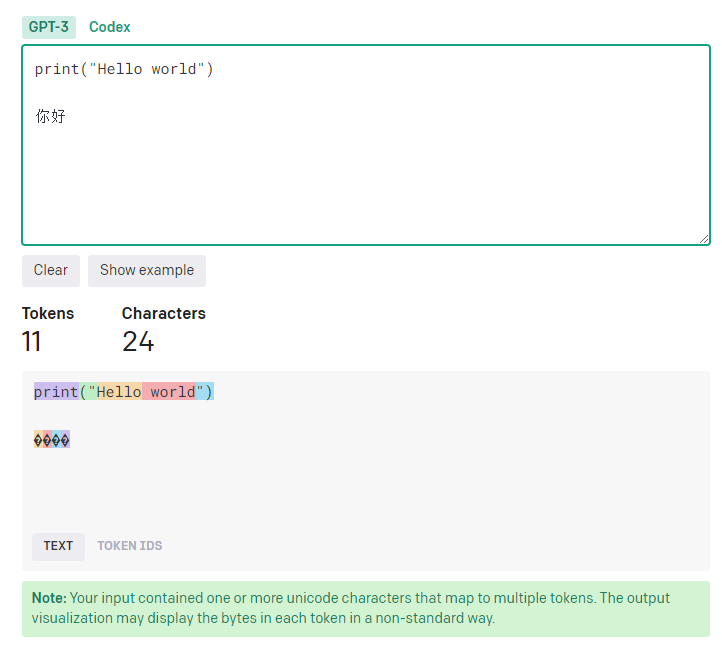

In [2]:
import tiktoken

OpenAI 不同的模型使用的 Token 编码方式是不同的。

| Encoding name           | OpenAI models                                       |
|-|-|
| `cl100k_base`           | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002`  |
| `p50k_base`             | Codex models, `text-davinci-002`, `text-davinci-003`|
| `r50k_base` (or `gpt2`) | GPT-3 models like `davinci`  |

In [41]:
encoding = tiktoken.get_encoding("p50k_base")
# or
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
# encoding = tiktoken.encoding_for_model("text-davinci-003")


用 `encode` 方法将文本转换为 Token。

In [48]:
hello_token = encoding.encode("你好")
hello_token

[57668, 53901]

In [47]:
print(encoding.decode(hello_token))
# 解码单个 token
print([encoding.decode([token]) for token in hello_token])


你好
['你', '好']


In [23]:
tokens = [encoding.decode_single_token_bytes(token) for token in encoding.encode("你好")]
print(tokens)


[b'\xe4\xbd', b'\xa0', b'\xe5\xa5', b'\xbd']


'你'

In [24]:
(tokens[0] + tokens[1]).decode("utf-8")


'你'


## 模型种类

OpenAI 模型从功能上可以分为三大类：补全（completion）、对话（chat）、嵌入（embeddings）

### 补全

补全模型可以根据输入的文本，补全剩余的文本。这类模型顾名思义，就是根据前文

### 对话

对话模型是专门为对话场景设计的模型。对话模型可以根据上文，生成下文。对话模型的输入是一个对话历史，输出是下一句话。

### 嵌入

嵌入模型可以将文本转换为向量。这类模型可以用于文本分类、聚类、搜索等任务。

## API 参数

- `model` 指定使用的模型。
- `prompt` 是输入给模型的文本。
- `temperature` 控制了生成文本的随机程度，值越大，生成的文本越随机，值越小，生成的文本越稳定。这个值的范围在 0.0 到 2.0 之间（虽然在 Playground 中最高只能设为 1）。
- `top_p` 与 `temperature` 类似，也是控制生成文本的随机程度。但这个参数简单的说是控制候选词的范围，值越大，候选词的范围越大，值越小，候选词的范围越小。这个值的范围在 0.0 到 1.0 之间。通常来说，这两个参数只需要设置一个就可以了。
- `max_tokens` 是模型生成的文本的最大长度，这其中的 “token” 不是指字符长度，你可以把他理解为模型眼中的 “词”。Token 与我们所使用的词不一定是一一对应的。
- `stop` 是生成文本的停止条件，当生成的文本中包含这个字符串时，生成过程就会停止,最终生成的文本中将不包含这个字符串。这个参数可以是一个 string，也可以是一个长度至多为 4 的 string 列表。
- `presence_penalty` 控制生成文本的多样性。他会惩罚那些在生成文本中已经出现过的 token，以减小未来生成这些 token 的概率。这个值的范围在 -2.0 到 2.0 之间。如果设为负值，那么惩罚就会变为奖励，这样就会增加生成这些 token 的概率。
- `frequency_penalty` 与 `presence_penalty` 类似，也是控制生成文本的多样性。但不同的是，`presence_penalty` 是一次性惩罚，而 `frequency_penalty` 累计惩罚。如果一个词在生成文本中出现了多次，那么这个词在未来生成的概率就会越来越小。这个值的范围同样在 -2.0 到 2.0 之间。

In [3]:
import openai
import json

with open("../config.json") as f:
    config = json.load(f)

# 设置 API
openai.api_key = config["api_key"]
openai.api_base = config["api_base"]
openai.api_type = "azure"
openai.api_version = "2023-03-15-preview"  # this may change in the future
model = "gpt-35-turbo"  # Model deployment name


### openai.Completion()

In [39]:
prompt = "1, 2, 3, 4, "
response = openai.Completion.create(
    engine=model, prompt=prompt, max_tokens=50, temperature=0.0
)
print(response)

{
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,"
    }
  ],
  "created": 1681823116,
  "id": "cmpl-76fJEVStxeTAVzIJtgDur8EHk3ri4",
  "model": "gpt-35-turbo",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 50,
    "prompt_tokens": 12,
    "total_tokens": 62
  }
}


In [51]:
a = "".join(sorted(str(759)))
b = "".join(sorted(str(759))[::-1])
print(a, b)

579 975


`finish_reason`：停止原因，可以是 `length` / `stop`。
`usage`：Token 的使用情况
- `completion_tokens`：生成了多少个 Token
- `prompt_tokens`：输入了多少个 Token
- `total_tokens`：总共使用了多少个 Token

添加 `stop` 参数，可以防止生成的文本过长，也可以避免生成不必要的内容。

In [37]:
prompt = "1, 2, 3, 4, "
response = openai.Completion.create(
    engine=model, prompt=prompt, temperature=0, stop=["11"]
)
print(response["choices"][0])

{
  "finish_reason": "length",
  "index": 0,
  "logprobs": null,
  "text": "5, 6, 7, 8, 9, 10"
}


### openai.ChatCompletion()

In [2]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Does Azure OpenAI support customer managed keys?"},
    {
        "role": "assistant",
        "content": "Yes, customer managed keys are supported by Azure OpenAI.",
    },
    {"role": "user", "content": "Do other Azure Cognitive Services support this too?"},
]

response = openai.ChatCompletion.create(
    engine=model, messages=messages, temperature=0.8
)
response


<OpenAIObject chat.completion id=chatcmpl-76gY25VgqhD2phu1bTBVrMo9qHdaJ at 0x1ed5523dd90> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Yes, other Azure Cognitive Services also support customer managed keys. This includes services such as Azure Text Analytics, Azure Speech Services, and Azure Translator. With customer managed keys, you can create and manage your own encryption keys to protect your data in Azure Cognitive Services. This can help you meet compliance and regulatory requirements, and provide an additional layer of security for your data.",
        "role": "assistant"
      }
    }
  ],
  "created": 1681827878,
  "id": "chatcmpl-76gY25VgqhD2phu1bTBVrMo9qHdaJ",
  "model": "gpt-35-turbo",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 73,
    "prompt_tokens": 59,
    "total_tokens": 132
  }
}

In [8]:
conversation = [{"role": "system", "content": "You are a helpful assistant."}]
# [{"role": "system", "content": "You are a helpful assistant."}]

while user_input := input():
    conversation.append({"role": "user", "content": user_input})
    print("Thinking...")
    response = openai.ChatCompletion.create(
        engine=model,
        messages=conversation,
    )

    conversation.append(
        {"role": "assistant", "content": response.choices[0].message.content}
    )
    print("\n" + response.choices[0].message.content + "\n")
print(conversation)

Thinking...

Is there a question or task you need help with?

Thinking...

1+1=2

Thinking...

2+2=4

Thinking...

45*23=1035

[{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '1,2,3'}, {'role': 'assistant', 'content': 'Is there a question or task you need help with?'}, {'role': 'user', 'content': '1+1等于几'}, {'role': 'assistant', 'content': '1+1=2'}, {'role': 'user', 'content': '2+2呢'}, {'role': 'assistant', 'content': '2+2=4'}, {'role': 'user', 'content': '45*23'}, {'role': 'assistant', 'content': '45*23=1035'}]


### 流式生成

In [16]:
response = openai.ChatCompletion.create(
    engine=model,
    messages=[
        {"role": "user", "content": "用 Python 写一个汉内塔"},
    ],
    temperature=0.5,
    stream=True,
)
next(response)
for chunk in response:
    print(chunk.choices[0].delta.get("content", ""), end="")

以下是 Python 实现汉诺塔的代码：

```python
def hanoi(n, A, B, C):
    if n == 1:
        print(A, "->", C)
    else:
        hanoi(n-1, A, C, B)
        print(A, "->", C)
        hanoi(n-1, B, A, C)

n = int(input("请输入汉诺塔的层数："))
hanoi(n, "A", "B", "C")
```

运行结果：

```
请输入汉诺塔的层数：3
A -> C
A -> B
C -> B
A -> C
B -> A
B -> C
A -> C
```

In [17]:
response = openai.ChatCompletion.create(
    engine=model,
    messages=[
        {"role": "user", "content": "Count to 10. E.g. 1, 2, 3, 4, ..."},
    ],
    temperature=0,
    stream=True,
)
print(next(response))
for chunk in response:
    print(chunk.choices)


{
  "choices": [
    {
      "delta": {
        "role": "assistant"
      },
      "finish_reason": null,
      "index": 0
    }
  ],
  "created": 1681829262,
  "id": "chatcmpl-76guMAB8iH47iy2QZy1t1VRZoAwrj",
  "model": "gpt-35-turbo",
  "object": "chat.completion.chunk"
}
[<OpenAIObject at 0x2031d183950> JSON: {
  "delta": {
    "content": "1"
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObject at 0x2031d1823f0> JSON: {
  "delta": {
    "content": ","
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObject at 0x2031d1822d0> JSON: {
  "delta": {
    "content": " "
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObject at 0x2031d1827b0> JSON: {
  "delta": {
    "content": "2"
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObject at 0x2031d183950> JSON: {
  "delta": {
    "content": ","
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObject at 0x2031d1823f0> JSON: {
  "delta": {
    "content": " "
  },
  "finish_reason": null,
  "index": 0
}]
[<OpenAIObje

### 异步调用

异步可以让我们等待结果的同时，继续执行其他的代码，这样就不会阻塞程序的执行了。

In [27]:
import random
import time


def wait_for_response(n: int):
    t = random.randint(1, 2)
    time.sleep(t)
    print(f"{n}: {t} seconds")


def main():
    for i in range(5):
        wait_for_response(i)


start = time.time()
main()
print(f"Total time: {time.time() - start}")


0: 1 seconds
1: 1 seconds
2: 2 seconds
3: 1 seconds
4: 1 seconds
Total time: 6.002270221710205


In [31]:
import random
import asyncio

async def wait_for_response(n:int):
    t = random.randint(1, 2)
    await asyncio.sleep(t)
    print(f"{n}: {t} seconds")
    
async def main():
    await asyncio.gather(*[wait_for_response(i) for i in range(5)])

start = time.time() 
await main()
print(f"Total time: {time.time() - start}")

1: 1 seconds
3: 1 seconds
4: 1 seconds
0: 2 seconds
2: 2 seconds
Total time: 2.023716688156128


In [32]:
async def async_completion():
    response = await openai.ChatCompletion.acreate(
        engine=model,
        messages=[
            {"role": "user", "content": "Count to 10. E.g. 1, 2, 3, 4, ..."},
        ],
        temperature=0,
    )
    return response.choices[0].message


print(await async_completion())


{
  "content": "1, 2, 3, 4, 5, 6, 7, 8, 9, 10.",
  "role": "assistant"
}


手动传入 aiohttp.ClientSession 对象

In [33]:
from aiohttp import ClientSession
import asyncio

openai.aiosession.set(ClientSession())
res = await asyncio.gather(*[async_completion() for _ in range(10)])
await openai.aiosession.get().close()

参考资料：
- OpenAI API Reference: https://platform.openai.com/docs/api-reference
- openai/openai-cookbook: https://github.com/openai/openai-cookbook
- 